In [1]:
# 필요한 라이브러리 import
import torch  # PyTorch 라이브러리
import torch.nn as nn  # PyTorch의 신경망 모듈
import torch.optim as optim  # PyTorch의 최적화 모듈
from torch.utils.data import DataLoader, Dataset  # PyTorch의 데이터 로더와 데이터셋 클래스
from torchvision.datasets import FashionMNIST  # Fashion-MNIST 데이터셋
from torchvision import transforms  # 이미지 변환 도구
import matplotlib.pyplot as plt  # 시각화 라이브러리

In [2]:
# Fashion-MNIST 데이터셋 로드 및 정규화
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차를 사용하여 정규화
])

# Fashion-MNIST 훈련 데이터셋 로드
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Fashion-MNIST 테스트 데이터셋 로드
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # 훈련 데이터로더
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  # 테스트 데이터로더

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=5)  # 1채널 입력, 9채널 출력, 5x5 커널
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 최대 풀링
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=18, kernel_size=3)  # 9채널 입력, 18채널 출력, 3x3 커널
        self.fc1 = nn.Linear(18 * 5 * 5, 64)  # 18x5x5 크기의 피처 맵을 64개의 노드로 연결하는 완전 연결 레이어
        self.fc2 = nn.Linear(64, 10)  # 64개의 노드를 10개의 클래스로 연결하는 완전 연결 레이어 (출력 레이어)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 컨볼루션, 활성화 함수, 풀링
        x = self.pool(torch.relu(self.conv2(x)))  # 컨볼루션, 활성화 함수, 풀링
        x = x.view(-1, 18 * 5 * 5)  # 벡터로 변환
        x = torch.relu(self.fc1(x))  # 완전 연결 레이어, 활성화 함수
        x = self.fc2(x)  # 출력 레이어
        return x

In [4]:
# 모델, 손실 함수, 최적화 함수 초기화
model = SimpleCNN()  # CNN 모델 인스턴스 생성
criterion = nn.CrossEntropyLoss()  # 손실 함수: 교차 엔트로피 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 최적화 알고리즘: Adam 최적화, 학습률 0.001

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 여부 확인
model.to(device)  # 모델을 GPU로 이동


SimpleCNN(
  (conv1): Conv2d(1, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=450, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
# 훈련 및 평가 함수 정의
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_loss_history = []  # 훈련 손실 이력 저장 리스트
    train_acc_history = []  # 훈련 정확도 이력 저장 리스트
    test_loss_history = []  # 테스트 손실 이력 저장 리스트
    test_acc_history = []  # 테스트 정확도 이력 저장 리스트

    for epoch in range(1, epochs + 1):  # 주어진 에포크만큼 반복
        model.train()  # 모델을 훈련 모드로 설정
        running_loss = 0.0  # 훈련 손실 초기화
        correct_train = 0  # 올바르게 분류된 훈련 샘플 수 초기화
        total_train = 0  # 훈련 샘플의 총 수 초기화
        for images, labels in train_loader:  # 각 배치마다 반복
            images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(images)  # 모델에 데이터 전달하여 출력 계산
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파 실행
            optimizer.step()  # 최적화 단계 수행

            running_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs.data, 1)  # 각 배치의 예측값 계산
            total_train += labels.size(0)  # 배치의 레이블 수 누적
            correct_train += (predicted == labels).sum().item()  # 올바르게 분류된 샘플 수 누적

        train_loss = running_loss / len(train_loader)  # 훈련 손실 계산
        train_accuracy = 100 * correct_train / total_train  # 훈련 정확도 계산

        test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)  # 테스트 데이터셋으로 모델 평가

        # 에포크마다 결과 출력
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # 결과 이력에 추가
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_accuracy)

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history

In [6]:
# 모델 평가 함수 정의
def evaluate_model(model, criterion, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0  # 평가 손실 초기화
    correct = 0  # 올바르게 분류된 테스트 샘플 수 초기화
    total = 0  # 테스트 샘플의 총 수 초기화
    with torch.no_grad():  # 그래디언트를 계산하지 않도록 설정
        for images, labels in test_loader:  # 각 배치마다 반복
            images, labels = images.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(images)  # 모델에 데이터 전달하여 출력 계산
            loss = criterion(outputs, labels)  # 손실 계산

            running_loss += loss.item()  # 손실 누적
            _, predicted = torch.max(outputs.data, 1)  # 각 배치의 예측값 계산
            total += labels.size(0)  # 배치의 레이블 수 누적
            correct += (predicted == labels).sum().item()  # 올바르게 분류된 샘플 수 누적

    test_loss = running_loss / len(test_loader)  # 테스트 손실 계산
    test_accuracy = 100 * correct / total  # 테스트 정확도 계산

    return test_loss, test_accuracy

# 모델 훈련 및 결과 저장
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist = train_model(model, criterion, optimizer, train_loader, test_loader, epochs=5)


Epoch [1/5], Train Loss: 0.6522, Train Accuracy: 76.62%, Test Loss: 0.4834, Test Accuracy: 82.36%
Epoch [2/5], Train Loss: 0.4256, Train Accuracy: 84.79%, Test Loss: 0.4064, Test Accuracy: 85.16%
Epoch [3/5], Train Loss: 0.3686, Train Accuracy: 86.65%, Test Loss: 0.3749, Test Accuracy: 86.60%
Epoch [4/5], Train Loss: 0.3334, Train Accuracy: 87.99%, Test Loss: 0.3402, Test Accuracy: 87.48%
Epoch [5/5], Train Loss: 0.3109, Train Accuracy: 88.80%, Test Loss: 0.3291, Test Accuracy: 87.83%


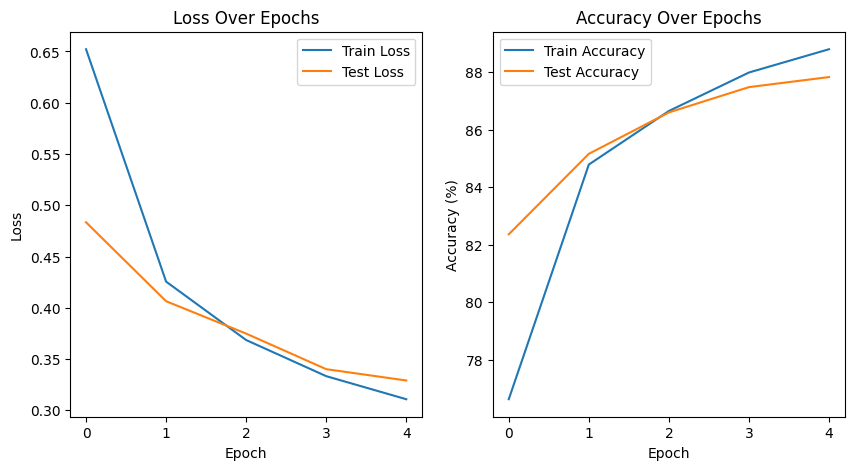

In [7]:
# 결과 그래프 그리기
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(test_acc_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()